<a href="https://colab.research.google.com/github/govindramesh/segment-anything/blob/main/notebooks/Fine_Tuning_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install torch torchvision torchmetrics &> /dev/null
! pip install matplotlib &> /dev/null
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [38]:
%cd /home/govind/segment-anything

/home/govind/segment-anything


In [39]:
from segment_anything import SamPredictor, sam_model_registry
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
import os

In [4]:
checkpoint = 'sam_vit_b_01ec64.pth'
sam = sam_model_registry['vit_b'](checkpoint=checkpoint)
predictor = SamPredictor(sam)


In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, mask_dir):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx][:3]+"_label.PNG")

        image = np.asarray(Image.open(img_name))
        mask = np.asarray(Image.open(mask_name))

        return image, mask

In [7]:
# Load custom dataset
dataset = CustomDataset(root_dir='data/Images', mask_dir='data/Masks')

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [8]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [95, 23])

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor.model.to(device)
predictor.model.train()

In [11]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([60]).to(device))

optimizer = torch.optim.Adam(predictor.model.mask_decoder.parameters(), lr=.000001)


In [ ]:
for name, param in predictor.model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
  else:
    param.requires_grad_(True)

In [14]:
for epoch in range(20):
    predictor.model.train(True)
    training_loss = 0.0
    for i, data in tqdm(enumerate(train_dataloader, 0), total=len(train_dataloader)):
        inputs, labels = data
        labels = labels.to(device)/255

        inputs = inputs.to(device)

        optimizer.zero_grad()

        predictor.set_image(np.asarray(inputs[0].cpu()))
        masks, scores, logits = predictor.predict(
            multimask_output=False,
            return_logits=True
        )

        loss = criterion(masks[0], labels.float())
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    predictor.model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader, 0), total=len(test_dataloader)):
            inputs, labels = data
            labels = labels.to(device)/255

            inputs = inputs.to(device)

            predictor.set_image(np.asarray(inputs[0].cpu()))
            masks, scores, logits = predictor.predict(
                multimask_output=False,
                return_logits=True
            )
            
            loss = criterion(masks[0], labels.float())
            test_loss += loss.item()

    print(f"EPOCH {epoch+1}")
    print(f"TRAINING LOSS: {training_loss/len(train_dataloader)}")
    print(f"TEST LOSS: {test_loss/len(test_dataloader)}")
    
print('Finished Training')

  0%|          | 0/95 [00:00<?, ?it/s]/home/govind/miniconda3/envs/sam/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
100%|██████████| 23/23 [00:03<00:00,  5.99it/s]


TRAINING LOSS: 1.3308406666705483
TEST LOSS: 1.225056080714516


100%|██████████| 23/23 [00:03<00:00,  5.95it/s]


TRAINING LOSS: 1.1909915321751645
TEST LOSS: 1.0762257886969524


100%|██████████| 23/23 [00:03<00:00,  5.91it/s]


TRAINING LOSS: 1.0228871850590957
TEST LOSS: 0.9330488819143047


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


TRAINING LOSS: 0.822345434521374
TEST LOSS: 0.7122536256261494


100%|██████████| 23/23 [00:03<00:00,  5.84it/s]


TRAINING LOSS: 0.6258885429093712
TEST LOSS: 0.5862040176339771


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


TRAINING LOSS: 0.5197214427747224
TEST LOSS: 0.5249960383643275


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


TRAINING LOSS: 0.454345250757117
TEST LOSS: 0.49265377806580585


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


TRAINING LOSS: 0.42464275744400526
TEST LOSS: 0.4714682996273041


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


TRAINING LOSS: 0.3992044529632518
TEST LOSS: 0.46497398776852567


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


TRAINING LOSS: 0.38665228705657156
TEST LOSS: 0.43872918350541074


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


TRAINING LOSS: 0.3816793716267536
TEST LOSS: 0.431762235644071


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


TRAINING LOSS: 0.3704144857431713
TEST LOSS: 0.4230788026166999


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


TRAINING LOSS: 0.36503448392215526
TEST LOSS: 0.4177313301226367


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


TRAINING LOSS: 0.3580667400046399
TEST LOSS: 0.4150935165260149


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


TRAINING LOSS: 0.35332478041711607
TEST LOSS: 0.4133302119115125


100%|██████████| 23/23 [00:03<00:00,  5.81it/s]


TRAINING LOSS: 0.3494146605071269
TEST LOSS: 0.40619912840749905


100%|██████████| 23/23 [00:03<00:00,  5.81it/s]


TRAINING LOSS: 0.3459647234333189
TEST LOSS: 0.40395591116469837


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


TRAINING LOSS: 0.34179737497317164
TEST LOSS: 0.4053545007887094


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


TRAINING LOSS: 0.3384746338976057
TEST LOSS: 0.4109904639746832


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]

TRAINING LOSS: 0.3361708954760903
TEST LOSS: 0.41474175906699634
Finished Training


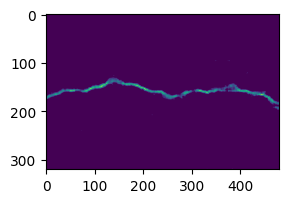

In [29]:
plt.figure(figsize=(3,3))
label = np.asarray(mask.squeeze().detach().cpu())
plt.imshow(label)

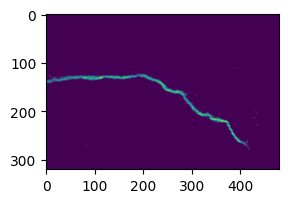

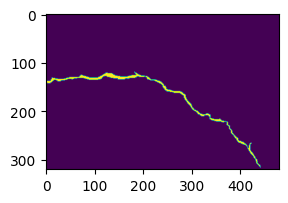

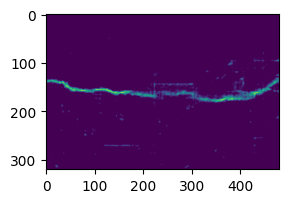

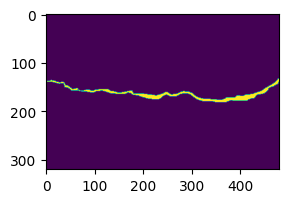

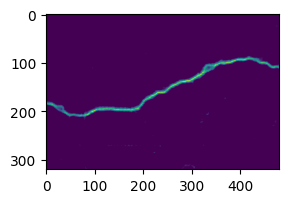

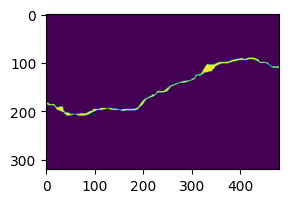

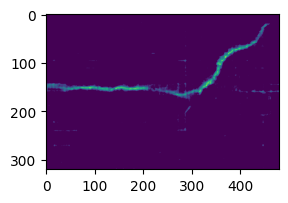

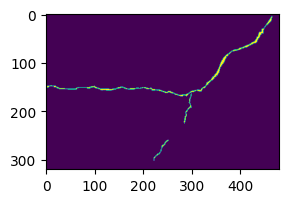

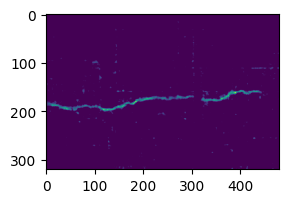

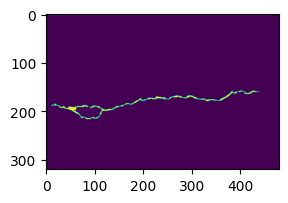

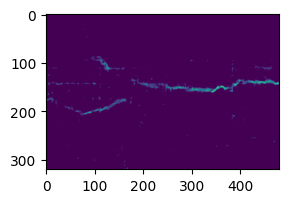

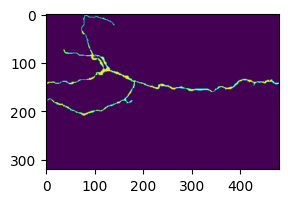

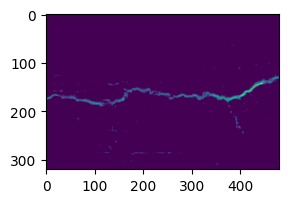

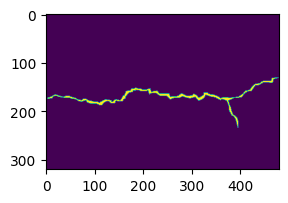

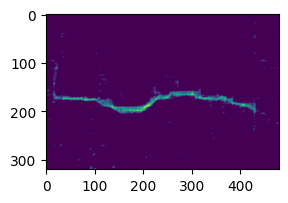

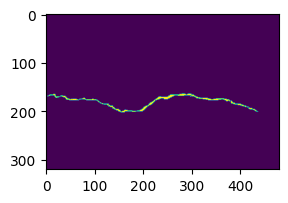

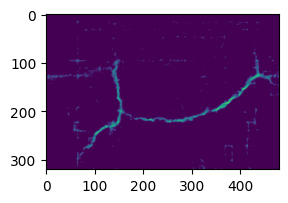

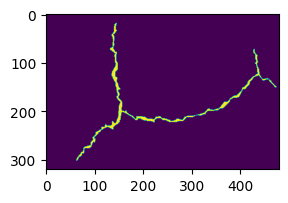

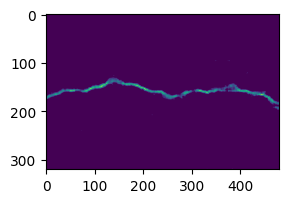

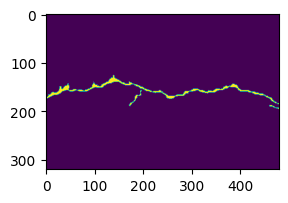

In [28]:
for i in range(10):
    with torch.no_grad():
        item = test_dataset.__getitem__(i)[0]
        predictor.set_image(item)
        mask, score, logit = predictor.predict(
            multimask_output=False,
            return_logits=True
        )

    mask[mask < 0] = 0
    plt.figure(figsize=(3,3))
    output = np.asarray(mask.squeeze().detach().cpu())
    plt.imshow(output)
    plt.figure(figsize=(3,3))
    label = np.asarray(test_dataset.__getitem__(i)[1])
    plt.imshow(label)

In [32]:
params = []
for param in predictor.model.mask_decoder.parameters():
    params.append(param.view(-1))
params = torch.cat(params)
print(params.shape)
params[0:10]

torch.Size([4058340])


tensor([-0.0184, -0.0151, -0.0518, -0.0553, -0.0012,  0.0530,  0.0285,  0.0343,
         0.0216,  0.0439], device='cuda:0', grad_fn=<SliceBackward0>)